In [121]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from matplotlib.ticker import MultipleLocator

%matplotlib inline

In [122]:

df = pd.read_csv('per_minute.csv')

total_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['total']
})

member_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['member']
})


moving_average = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['mv10']
})


In [123]:
time_labels = pd.to_datetime(total_messages_per_minute['minute'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['minute'][::10]

In [124]:
mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['minute'], unit='m').dt.strftime('%H:%M:%S')

peaks

,minute,message_count,text_minute
5,5,209,00:05:00
51,51,149,00:51:00
62,62,139,01:02:00
71,71,192,01:11:00
78,78,135,01:18:00
96,96,139,01:36:00
99,99,160,01:39:00
100,100,219,01:40:00
101,101,184,01:41:00
102,102,224,01:42:00


In [125]:
peak_start_end = pd.DataFrame({
    'minute': total_messages_per_minute['minute'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

start_end_times.head()

is_above_average
2       (1, 1)
4       (5, 9)
6     (20, 20)
8     (24, 25)
10    (27, 27)
dtype: object

In [126]:
range_threashold = 3
merged_intervals = []
previous_start, previous_end = None, None

for start, end in start_end_times:
    if previous_start is None:
        # Initialize the first interval
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        # Merge the intervals if the gap is less than threashold
        previous_end = end
    else:
        # Save the previous interval and start a new one
        merged_intervals.append((previous_start, previous_end))
        previous_start, previous_end = start, end

# Append the last interval
if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))

merged_intervals

[(np.int64(1), np.int64(1)),
 (np.int64(5), np.int64(9)),
 (np.int64(20), np.int64(20)),
 (np.int64(24), np.int64(27)),
 (np.int64(33), np.int64(37)),
 (np.int64(42), np.int64(51)),
 (np.int64(55), np.int64(55)),
 (np.int64(61), np.int64(63)),
 (np.int64(68), np.int64(73)),
 (np.int64(78), np.int64(78)),
 (np.int64(84), np.int64(87)),
 (np.int64(92), np.int64(102)),
 (np.int64(109), np.int64(109)),
 (np.int64(117), np.int64(123)),
 (np.int64(133), np.int64(146)),
 (np.int64(152), np.int64(158)),
 (np.int64(164), np.int64(164)),
 (np.int64(168), np.int64(170)),
 (np.int64(177), np.int64(191)),
 (np.int64(195), np.int64(207)),
 (np.int64(211), np.int64(211))]

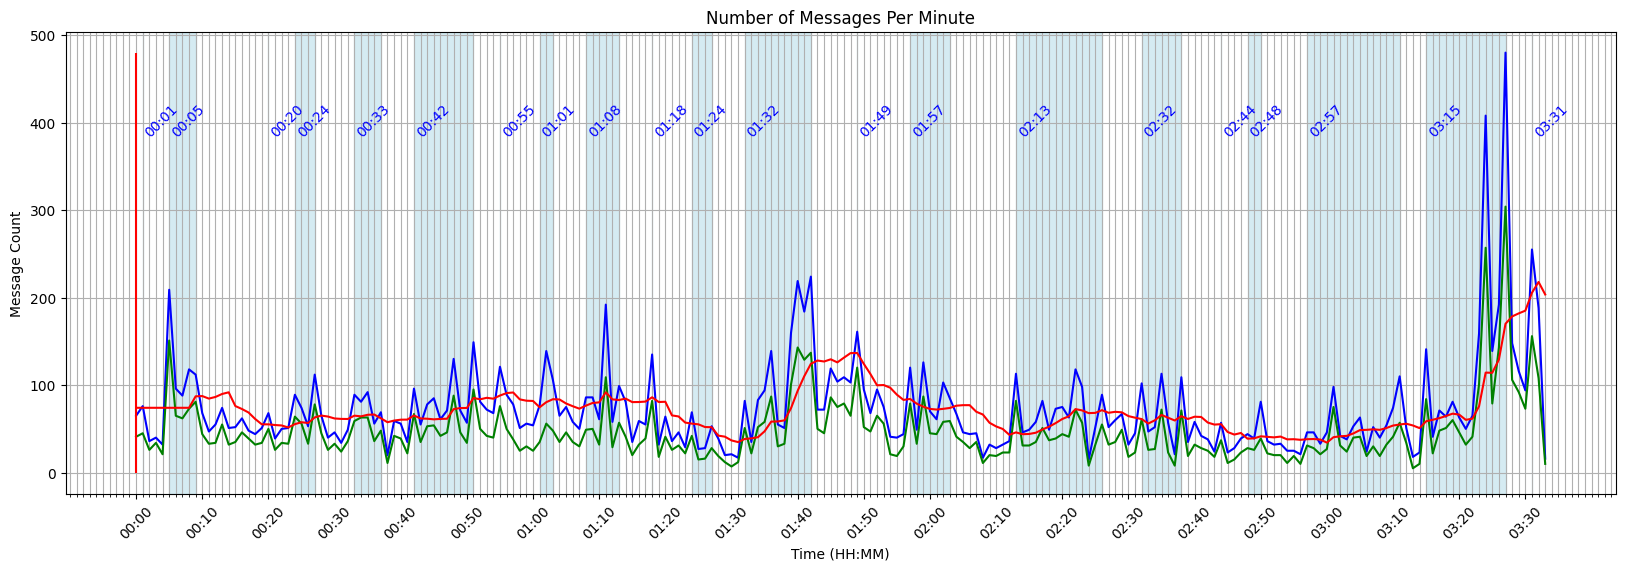

In [127]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['minute'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['minute'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['minute'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.show()